In [1]:
import re
import pandas as pd
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import datetime

In [2]:
class ExtractDataFrame:
    
    '''
    This module will help parsing the whatsapp chats data.
    Parameters:
        File_path (string): The path of the chats files
    Functions:
        Note: Object here refers to self

        load_file(object) -> File pointer
        is_newEntry(object, string) -> Boolean
        seperateData(object, string) -> Tuple
        process(object) -> NA
        emojis(object, string) -> List
        dataframe(object) -> Pandas DataFrame
    '''
    
    def __init__(self, file_path):
        '''
        Initializes the file path and data variable holding whole parsed data
        '''
        self.path = file_path
        self.data = []
        
    def load_file(self):
        '''
        This function loads the chat file
        '''
        file = open(self.path, 'r', encoding='utf-8')
        return file
    
    def is_newEntry(self, line: str) -> bool:
        '''
        This function returns if the line is a new message or continuation of the previous one
        '''
        date_time = '([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
        test = re.match(date_time, line)
        if test is not None:
            return True
        else:
            return False
        
    def seperateData(self, line: str) -> tuple:
        '''
        This function cleans the line and seperates the author, date, time and message from the text
        '''
        entry_data = line.split(' - ')
        date, time = entry_data[0].split(', ')
        authMsg = entry_data[1].split(':')
        if len(authMsg) > 1:
            author = authMsg[0]
            message = ' '.join(authMsg[1:])
            return (date, time, author, message)
        else:
            return None
    
    def process(self):
        '''
        This functions aggregates all the data from different lines
        '''
        f = self.load_file()
        f.readline()
        full_message = []
        while True:
            line = f.readline()
            if not line:
                break
                
            if self.is_newEntry(line):
                
                if len(full_message)>0:
                    temp = ' '.join(full_message)
                    modified_replaced = temp.replace('\n', ' ')
                    self.data.append([date, time, author, modified_replaced])
                    
                full_message.clear()
                received = self.seperateData(line)
                if received is not None:
                    date, time, author, message = received
                    full_message.append(message)
            else:
                full_message.append(line)

        f.close()
        
    def emojis(self, msg: str) -> list:
        '''
        This function returns the list of emojis present in a message. 
        Note: This will recoginize some of the hindi characters as emojis.
        '''
        final_list = []
        for char in msg:
            if char in emoji.UNICODE_EMOJI:
                final_list.append(char)
                
        if len(final_list)==0:
            return 0
        else:
            return final_list
        
    def dataframe(self) -> object:
        '''
        This function returns processed data in Pandas dataframe
        '''
        df = pd.DataFrame(self.data, columns=['Date', 'Time', 'Author', 'Message'])
        df['Date'] = pd.to_datetime(df.Date)
        df['Emojis'] = df.Message.apply(self.emojis)
        df['Emoji_num'] = df.Emojis.str.len()
        return df

In [37]:
chats = ExtractDataFrame('WhatsApp Chat with Shahbad Roots - Family.txt')

In [38]:
chats.process()

In [39]:
df = chats.dataframe()

In [40]:
df

,Date,Time,Author,Message,Emojis,Emoji_num
0,2019-03-25,05:33,didi new,<Media omitted>,0,NaN
1,2019-03-25,07:33,didi new,<Media omitted>,0,NaN
2,2019-03-25,08:35,Babbooji,<Media omitted>,0,NaN
3,2019-03-25,08:35,Babbooji,*🙏🌹जय श्री महाकाल 🌹🙏* *श्री महाकालेश्वर ज्यो...,"[🙏, 🌹, 🌹, 🙏, 🔱, 🎨, 🎨, 🔱]",8.0
4,2019-03-25,09:37,didi new,<Media omitted>,0,NaN
...,...,...,...,...,...,...
8939,2020-03-11,05:46,didi new,<Media omitted>,0,NaN
8940,2020-03-11,05:46,didi new,<Media omitted>,0,NaN
8941,2020-03-11,08:08,Babbooji,<Media omitted>,0,NaN
8942,2020-03-11,08:15,Babbooji,<Media omitted>,0,NaN


# Group Stats

In [41]:
class GenerateStats:
    
    '''
    This class of functions will be used to generate stats for any dataframe. 
    Full Group chats, any specific timeline or explicitly mentioned.
    Parameters:
        df (dataframe object): In all functions, only this needs to be passed.
    Functions:
        Note: Object here refers to self
        
        mediaRatio(object, dataframe) -> int
        totalEmojis(object, dataframe) -> int
        uniqueEmojis(object, dataframe) -> int
        frequentEmojis(object, dataframe) -> dataframe
        activeMembers(object, dataframe) -> dataframe
        lazyMembers(object, dataframe) -> dataframe
        activityOverDates(object, dataframe) -> matplotlib_graph
        activityOverTime(object, dataframe) -> matplotlib_graph
        holidaysDataFrame(object, dataframe) -> dict
        nightOwls_earlyBirds(object, dataframe) -> dict
        emojiCon_Emojiless(object, dataframe) -> dict
    '''
    
    def __init__(self):
        '''
        Here all the important initializations are done
        '''
        self.holidays_dict = {datetime.date(2020, 1, 14): 'Makar Sankranti / Pongal',
                              datetime.date(2020, 1, 26): 'Republic Day',
                              datetime.date(2020, 8, 15): 'Independence Day',
                              datetime.date(2020, 10, 2): 'Gandhi Jayanti',
                              datetime.date(2020, 12, 25): 'Christmas',
                             }
        
    def mediaRatio(self, df) -> int:
        '''
        This function returns the percentage of messages which are media
        '''
        return ((df[df['Message'] != ' <Media omitted> '].Message.count()) / (df.Message.count()))*100
    
    def totalEmojis(self, df) -> int:
        '''
        This function returns the total number of emojis in the group
        '''
        return len([i for j in df.Emojis[df.Emojis!=0] for i in j])
    
    def uniqueEmojis(self, df) -> int:
        '''
        This function returns the number unique emojis sent.
        '''
        return len(set([i for j in df.Emojis[df.Emojis!=0] for i in j]))
    
    def frequentEmojis(self, df) -> object:
        '''
        This function returns dataframe object consisting of frequent emojis of the group.
        If there are less than 10 frequent emojis then whole dataframe is returned
        '''
        emojiList = [i for j in df.Emojis[df.Emojis!=0] for i in j]
        emoji_dict = dict(Counter(emojiList))
        emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
        emoji_df = pd.DataFrame(emoji_dict, columns=['Emoji', 'Count'])
        if emoji_df.shape[0] <10:
            return emoji_df
        else:
            return emoji_df[:10]
        
    def activeMembers(self, df) -> object:
        '''
        This function returns dataframe object consisting of active members of the group.
        If there are less than 5 active members then whole dataframe is returned
        '''
        authors = pd.DataFrame(df.Author.value_counts())
        if authors.shape[0] < 5:
            return authors
        else:
            return authors[:5]
        
    def lazyMembers(self, df) -> object:
        '''
        This function returns dataframe object consisting of lazy members of the group.
        If there are less than 5 lazy members then whole dataframe is returned
        '''
        authors = pd.DataFrame(df.Author.value_counts())
        if authors.shape[0] < 5:
            return authors[::-1]
        else:
            return authors[-5:][::-1]
        
    def activityOverDates(self, df) -> object:
        '''
        This function returns matplotlib line graph showing activity of the group over the 
        all the dates
        '''
    
        # will make it plotly interactive
        plt.xlabel('Timeline')
        plt.ylabel('Number of messages')
        return df['Date'].value_counts().plot()
    
    def activityOverTime(self, df) -> object:
        '''
        This function returns matplotlib line graph showing activity of the group over the 
        all whole day
        '''
    
        # will make it plotly interactive
        plt.xlabel('Time')
        plt.ylabel('Number of messages')
        return df['Time'].value_counts().plot()
    
    def holidaysDataFrame(self, df) -> dict:
        '''
        Returns dict of dataframes which matches the holidays date pattern
        '''
        df_dict = {}
        for date, event in self.holidays_dict.items():
            temp = df[(df.Date.dt.day==date.day) & (df.Date.dt.month==date.month)]
            if temp.empty:
                temp = None
            df_dict[event] = temp

        return df_dict
    
    def nightOwls_earlyBirds(self, df) -> dict:
        '''
        This function will returns dict of two dataframes with authors who send most
        messages in night between 11 pm to 3 am and between 6 am to 9 am in the
        morning.
        If there are less than 3 members then whole dataframe is returned        
        '''
        df_dict_n = {}
        temp = pd.to_datetime(df.Time)
        morning_mask = (temp.dt.hour >= 6) & (temp.dt.hour <=9)
        night_mask = ~((temp.dt.hour >= 3) & (temp.dt.hour <=23))
        df_dict_n['morning'] = df[morning_mask].Author.value_counts()
        df_dict_n['night'] = df[night_mask].Author.value_counts()
        
        if df_dict_n['morning'].shape[0] > 3:
            df_dict_n['morning'] = df_dict_n['morning'][:3]
            
        if df_dict_n['night'].shape[0] >3:
            df_dict_n['night'] = df_dict_n['night'][:3]
            
        return df_dict_n
    
    def emojiCon_Emojiless(self, df) -> dict:
        '''
        This function will returns dict of two dataframes with authors who send most
        emojis and least emojis.
        If there are less than 3 members then whole dataframe is returned        
        '''
        df_dict_n2 = {}
        temp2 = pd.DataFrame(df.groupby('Author').Emoji_num.sum().sort_values(ascending=False))
        if temp2.shape[0] > 3:
            df_dict_n2['Emoji_con'] = temp2[:3]
            df_dict_n2['Emoji_less'] = temp2[-3:][::-1]
        else:
            df_dict_n2['Emoji_con'] = df_dict_n2['Emoji_less'] = temp2
            
        return df_dict_n2

In [42]:
obj = GenerateStats()

## Media Files to Messsages Ratio

In [43]:
obj.mediaRatio(df)

46.366279069767444

## Total Emojis

In [44]:
obj.totalEmojis(df)

20055

## Total Unique Emojis

In [45]:
obj.uniqueEmojis(df)

498

## Frequent Emojis

In [46]:
obj.frequentEmojis(df)

,Emoji,Count
0,🙏,3275
1,🌹,2206
2,🏻,1609
3,🚩,602
4,💐,514
5,〰,496
6,🕉,414
7,😊,339
8,🌷,333
9,🎂,327


## Most Active Members

In [47]:
obj.activeMembers(df)

,Author
Babbooji,4597
didi new,1962
Preeti Gupta,258
Nikunj,199
Manu Banglore,189


## Lazy Members

In [48]:
obj.lazyMembers(df)

,Author
Jijaji,2
+91 96205 10933,3
Babbal,3
Deepansh,4
Madhu,4


## Activity 

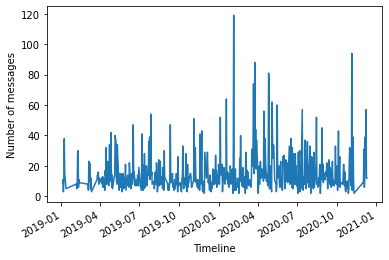

In [49]:
obj.activityOverDates(df);

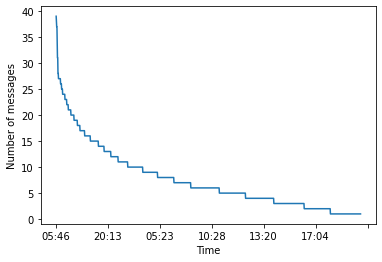

In [50]:
obj.activityOverTime(df);

## Holidays DataFrames

In [51]:
obj.holidaysDataFrame(df)

{'Makar Sankranti / Pongal':            Date   Time           Author  \
 3908 2020-01-14  06:15         didi new   
 3909 2020-01-14  06:15         didi new   
 3910 2020-01-14  08:11         Babbooji   
 3911 2020-01-14  08:13         Sureshji   
 3912 2020-01-14  08:16         Babbooji   
 3913 2020-01-14  08:19         Babbooji   
 3914 2020-01-14  08:28         Babbooji   
 3915 2020-01-14  08:35         Babbooji   
 3916 2020-01-14  08:43         Babbooji   
 3917 2020-01-14  11:56        Dk Kansal   
 3918 2020-01-14  11:56        Dk Kansal   
 3919 2020-01-14  11:56        Dk Kansal   
 3920 2020-01-14  11:56        Dk Kansal   
 3921 2020-01-14  11:56        Dk Kansal   
 3922 2020-01-14  12:21  +91 96205 10933   
 3923 2020-01-14  21:33  +91 96205 10933   
 3924 2020-01-14  21:58         Babbooji   
 3925 2020-01-14  21:59         Babbooji   
 
                                                 Message  \
 3908                                   <Media omitted>    
 3909         

## Nightowls, Earlybirds

In [52]:
obj.nightOwls_earlyBirds(df)

{'morning': Babbooji    2157
 didi new     638
 Atul          60
 Name: Author, dtype: int64,
 'night': Babbooji         27
 didi new         21
 Manu Banglore     8
 Name: Author, dtype: int64}

## Emojicon, Emojiless

In [53]:
obj.emojiCon_Emojiless(df)

{'Emoji_con':               Emoji_num
 Author                 
 Babbooji        15288.0
 Preeti Gupta      960.0
 didi new          946.0,
 'Emoji_less':           Emoji_num
 Author             
 Deepansh        0.0
 Madhu           0.0
 Jijaji          0.0}